## Benchmark for measuring performance of engineered features and models
Add features created from previous and next records in original order

In [1]:
import os
if os.name=='nt':
    try:
        mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
        os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
    except:
        pass

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sys import getsizeof
import time
import gc

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
import pickle

def save_pickle(x, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_pickle(filename):
    with open(filename, 'rb') as handle:
        x = pickle.load(handle)
    return x

In [3]:
from numba import jit

@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

@jit
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    new_mcc = 0
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc
    
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    return 'MCC', -best_mcc

In [24]:
def cross_val_predict_rskf(clf, x_train, y_train, n_splits=3, 
                           n_repeats=2, random_state=42, verbose=False, early_stopping=10):
    '''
    Repeated stratified KFold CV, returns predictions for 
    each repeat and average score.
    n_repeats: repetitions of CV
    to disable erlay stopping, set early_stopping to None
    '''
    scores = []
    n_trees = []
    clfs = []
    running_time = []
    
    rskf = RepeatedStratifiedKFold(n_repeats=n_repeats, n_splits=n_splits, 
                                   random_state=0)
    np.random.seed(random_state)
    for n, (train_index, test_index) in enumerate(rskf.split(x_train, y_train)):
        print('Round {}'.format(n))
        start_time = time.time()
        x_train_tmp, x_test_tmp = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_tmp, y_test_tmp = y_train.iloc[train_index], y_train.iloc[test_index]

        clf.random_state = np.random.randint(10000000)
        
        if early_stopping is not None:
            clf.fit(x_train_tmp, y_train_tmp, 
                    eval_set=[(x_test_tmp, y_test_tmp)], 
                    eval_metric=mcc_eval, early_stopping_rounds=early_stopping,
                    verbose=verbose)
            scores.append(-clf.best_score)
            n_trees.append(clf.best_ntree_limit)
        else:
            clf.fit(x_train_tmp, y_train_tmp)
            scores.append(eval_mcc(y_test_tmp.values, clf.predict_proba(x_test_tmp)[:, 1]))
            n_trees.append(clf.n_estimators)
        
        clfs.append(clf)
        running_time.append(time.time()-start_time)
        print('Split {}, score = {:.3f}, best_ntree_limit = {}, total time = {:.3f} min'.format(n, scores[n], 
            n_trees[n], sum(running_time)/60))

    print('Score mean = {:.3f}, std = {:.3f}'.format(np.mean(scores), np.std(scores)))
    
    return clfs, scores, n_trees, running_time

In [25]:
def cross_val_predict_skf_rm(clf, x_train, y_train, n_splits=3, 
                           n_repeats=2, random_state=42, verbose=False, early_stopping=10):
    '''
    Stratified KFold CV with repeated models
    to disable erlay stopping, set early_stopping to None
    '''
    scores = []
    n_trees = []
    clfs = []
    running_time = []

    skf = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True)
    np.random.seed(random_state)

    for m in range(n_repeats):
        print('Repeat {}'.format(m))
        for n, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
            start_time = time.time()
            x_train_tmp, x_test_tmp = x_train.iloc[train_index], x_train.iloc[test_index]
            y_train_tmp, y_test_tmp = y_train.iloc[train_index], y_train.iloc[test_index]

            clf.random_state = np.random.randint(10000000)
            # print(clf.random_state)

            if early_stopping is not None:
                clf.fit(x_train_tmp, y_train_tmp, 
                        eval_set=[(x_test_tmp, y_test_tmp)], 
                        eval_metric=mcc_eval, early_stopping_rounds=early_stopping,
                        verbose=verbose)
                scores.append(-clf.best_score)
                n_trees.append(clf.best_ntree_limit)
            else:
                clf.fit(x_train_tmp, y_train_tmp)
                scores.append(eval_mcc(y_test_tmp.values, clf.predict_proba(x_test_tmp)[:, 1]))
                n_trees.append(clf.n_estimators)
            
            clfs.append(clf)
            running_time.append(time.time() - start_time)
            print('Split {}, score = {:.3f}, n_best_trees = {}, total time = {:.3f} min'.format(n, 
                scores[m*n_repeats+n], n_trees[m*n_repeats+n], sum(running_time)/60))

    print('Score mean = {:.3f}, std = {:.3f}'.format(np.mean(scores), np.std(scores)))
    
    return clfs, scores, n_trees, running_time

In [6]:
# y_train = read_pickle('y_train.pickle')

# x_train = read_pickle('x_train_numeric_date_0.pickle')

### Load train and test data

In [9]:
# important numeric features are imported
important_features = pd.read_csv('benchmark_features/benchmark_1/important_numeric_features.csv', index_col=0, header=None)
important_features = list(important_features.values.ravel())
important_features.extend(['Id', 'Response'])

In [10]:
x_train_numeric = pd.read_csv('data/train_numeric.csv.zip', index_col=0, usecols=important_features, dtype=np.float32)

y_train = x_train_numeric.Response
x_train_numeric.drop(['Response'], axis=1, inplace=True)

In [11]:
date_train = pd.read_csv('benchmark_features/benchmark_2/train_station_flow.csv.gz', index_col=0, header=None)

In [12]:
x_train = x_train_numeric.join(date_train)

columns = list(x_train.columns)
columns[-1] = 'station_flow'
x_train.columns = columns

In [13]:
x_test_numeric = pd.read_csv('data/test_numeric.csv.zip', index_col=0, usecols=important_features[:-1], dtype=np.float32)

date_test = pd.read_csv('benchmark_features/benchmark_2/test_station_flow.csv.gz', index_col=0, header=None)

x_test = x_test_numeric.join(date_test)
x_test.columns = columns

In [14]:
x_train.index = x_train.index.astype(np.int64)
x_test.index = x_test.index.astype(np.int64)

In [15]:
del x_train_numeric, x_test_numeric
gc.collect()

786

### Create features

Use the original order to add features based on previous and next records.
- Response
- Feature hash equality for each station
- StartTime, EndTime

In [6]:
NROWS = None

# Load date data
date_train = pd.read_csv('data/train_date.csv.zip', index_col=0, dtype=np.float32, nrows=NROWS)

date_test = pd.read_csv('data/test_date.csv.zip', index_col=0, dtype=np.float32, nrows=NROWS)

# Load response data
response_train = pd.read_csv('data/train_numeric.csv.zip', index_col=0, usecols=[0, 969], 
                       dtype={'Id':np.int64, 'Response': np.int8}, nrows=NROWS)

response_test = pd.read_csv('data/sample_submission.csv.zip', index_col=0, 
                       dtype={'Id':np.int64, 'Response': np.int8}, nrows=NROWS)
response_test.Response = -1

# Concatenate train and test
response = response_train.append(response_test)
date = date_train.append(date_test)

del response_train, response_test, date_train, date_test
gc.collect()

487

In [7]:
dater = date.join(response, on='Id')

del date
gc.collect()

14

In [8]:
dater.index = dater.index.astype(np.int64)

dater.sort_index(inplace=True)

dater['response_previous'] = dater.Response.shift(1).fillna(-1).astype(np.int8)
dater['response_next'] = dater.Response.shift(-1).fillna(-1).astype(np.int8)

dater['time_start'] = dater.iloc[:,:-3].min(axis=1)
dater['time_end'] = dater.iloc[:,:-3].max(axis=1)
dater['time_duration'] = dater.time_end - dater.time_end

dater['time_start_previous'] = dater.time_start.shift(1).fillna(0)
dater['time_start_next'] = dater.time_start.shift(-1).fillna(0)

dater['time_end_previous'] = dater.time_end.shift(1).fillna(0)
dater['time_end_next'] = dater.time_end.shift(-1).fillna(0)

u = dater.iloc[:, :-10].values
a = np.apply_along_axis(lambda x: hash(tuple(x)), 1, u)

dater['hash'] = a

dater['hash_previous'] = dater['hash'].shift().fillna(0).astype(np.int64)
dater['hash_next'] = dater['hash'].shift(-1).fillna(0).astype(np.int64)

dater['hash_equal_previous'] = dater.hash == dater.hash_previous
dater['hash_equal_next'] = dater.hash == dater.hash_next

neighbors = dater.iloc[:, -15:]

neighbors.to_csv('benchmark_4_neighbors.csv.gz', compression='gzip')

### Load features

In [16]:
n = pd.read_csv('benchmark_features/benchmark_4/benchmark_4_neighbors.csv.gz', index_col=0)

neighbor_train = n.loc[n.Response!=-1]
neighbor_train.drop(['Response'], axis=1, inplace=True)

neighbor_test = n.loc[n.Response==-1]
neighbor_test.drop(['Response'], axis=1, inplace=True)

print(neighbor_test.shape, neighbor_train.shape)

x_trainn = x_train.join(neighbor_train, on='Id')
x_testn = x_test.join(neighbor_test, on='Id')

print(x_trainn.shape, x_testn.shape)

del x_train, x_test
gc.collect()

### CV score based on stratified KFold with repeated models

In [30]:
n_estimators = 20
clf = XGBClassifier(max_depth=14, n_estimators=n_estimators, 
                    base_score=0.0058, n_jobs=20, colsample_bytree=0.6,
                    min_child_weight=5, subsample=0.9,  
                    reg_lambda=4, silent=False, learning_rate=0.03)

clfs, scores, n_trees, running_time = cross_val_predict_skf_rm(clf, x_trainn, 
    y_train, n_splits=5, n_repeats=3, random_state=43196756, early_stopping=None, verbose=False)

Repeat 0
Split 0, score = 0.172, n_best_trees = 2, total time = 0.214 min
Split 1, score = 0.169, n_best_trees = 2, total time = 0.431 min
Split 2, score = 0.167, n_best_trees = 2, total time = 0.648 min
Split 3, score = 0.163, n_best_trees = 2, total time = 0.867 min
Split 4, score = 0.170, n_best_trees = 2, total time = 1.083 min
Repeat 1
Split 0, score = 0.163, n_best_trees = 2, total time = 1.297 min
Split 1, score = 0.170, n_best_trees = 2, total time = 1.515 min
Split 2, score = 0.172, n_best_trees = 2, total time = 1.733 min
Split 3, score = 0.169, n_best_trees = 2, total time = 1.953 min
Split 4, score = 0.164, n_best_trees = 2, total time = 2.171 min
Repeat 2
Split 0, score = 0.169, n_best_trees = 2, total time = 2.389 min
Split 1, score = 0.164, n_best_trees = 2, total time = 2.606 min
Split 2, score = 0.163, n_best_trees = 2, total time = 2.825 min
Split 3, score = 0.173, n_best_trees = 2, total time = 3.040 min
Split 4, score = 0.172, n_best_trees = 2, total time = 3.255 mi

[0]	validation_0-error:0.005811	validation_0-MCC:-0.173472
[1]	validation_0-error:0.005811	validation_0-MCC:-0.203626
[2]	validation_0-error:0.005811	validation_0-MCC:-0.227162
Optimal MCC = 0.198
Optimal threshold = 0.010


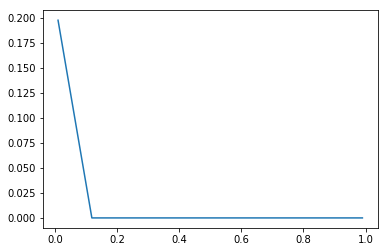

In [33]:
results = {'clfs': clfs, 'scores': scores, 'n_trees': n_trees, 'running_time': running_time}
save_pickle(results, 'benchmark_features/benchmark_4/results_benchmark_4_neighbors.pickle')

n_rounds = np.ceil(np.median(results['n_trees'])*5/4).astype(np.int)

clf = XGBClassifier(max_depth=14, n_estimators=n_rounds, 
                    base_score=0.0058, n_jobs=20, colsample_bytree=0.6,
                    min_child_weight=5, subsample=0.9,  
                    reg_lambda=4, silent=False, learning_rate=0.03, random_state=2345568)
clf.fit(x_trainn, y_train, 
        eval_set=[(x_trainn, y_train)], 
        eval_metric=mcc_eval, verbose=True)

y_train_pred = clf.predict_proba(x_trainn)[:, 1]

thresholds = np.linspace(0.01, 0.99, 400)
mcc = np.array([matthews_corrcoef(y_train, y_train_pred>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]

print('Optimal MCC = {:.3f}'.format(mcc.max()))
print('Optimal threshold = {:.3f}'.format(best_threshold))

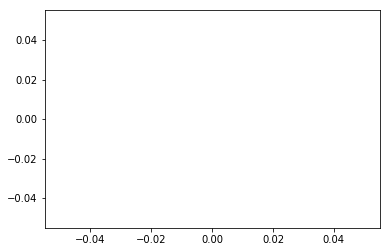

In [34]:
_, _, _ = plt.hist(y_train_pred, bins=100, range=(0.1, 0.8), normed=True, stacked=True)

### Load test data and predict

In [36]:
y_test_pred = clf.predict_proba(x_testn)[:, 1]
y_test_pred_int = (y_test_pred>best_threshold).astype(int)

sub = pd.read_csv("data/sample_submission.csv.zip", index_col=0)
sub["Response"] = y_test_pred_int
sub.to_csv("benchmark_features/benchmark_4/15-benchmark_4_neighbors_submission.csv.gz", compression="gzip")

public MCC = 0.22579, private MCC = 0.21225

CV MCC mean = 0.22643, std = 0.009
